In [1]:
# CSC 732 HW #2 Part 1 Linear Regression
# Dominic Klusek, Jonathan Rozen

In [2]:
from IPython.display import Image
# inline plotting instead of popping out
%matplotlib inline

# increase width of jupyter notebook cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# import libraries and functions
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, Normalizer, RobustScaler
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
import seaborn as sns

In [4]:
def dataset_split(dataset, class_labels, test_set_size=0.2, validation_set_size=0.1, Verbose=True):
    '''
        Function to split dataset into three subsets:
            - Training
            - Testing
            - Validation
        Parameters:
            dataset: array that supports indexing or size (number of samples, number of features)
            
            test_set_size: float between [0.0, 1.0] to determine the size of test_set
            
            validation_set_size: float between [0.0, 1.0] to determine the size of validation_set
            
        Outpus:
            training_dataset, testing_dataset, validation_dataset: arrays of data with sizes dependant on size parameters
    '''
    import math
    # get dataset shape
    dataset_shape = dataset.shape
    
    # shuffle dataset
    #dataset = shuffle(dataset)
    
    # create training dataset
    start_index = 0
    end_index = math.floor(dataset_shape[0] * (1.0 - test_set_size - validation_set_size))
    
    training_dataset = dataset[start_index:end_index+1]
    training_labels = class_labels[start_index:end_index+1]
    
    # create testing dataset
    start_index = end_index+1
    end_index = start_index + math.floor(dataset_shape[0] * test_set_size)
    
    validation_dataset = dataset[start_index:end_index+1]
    validation_labels = class_labels[start_index:end_index+1]
    
    # create validation dataset
    start_index = end_index+1
    end_index = dataset_shape[0]
    
    testing_dataset = dataset[start_index:end_index]
    testing_labels = class_labels[start_index:end_index]
    
    if Verbose:
        print("Testing Set Shape: ", training_dataset.shape)
        print("Validation Set Shape: ", validation_dataset.shape)
        print("Training Set Shape: ", testing_dataset.shape)
    
    # return datasets
    return training_dataset, training_labels, validation_dataset, validation_labels, testing_dataset, testing_labels

In [5]:
def seperate_boxplot(data, layout=(7,5), figsize=(15,10)):
    # create a main figure
    plt.figure(facecolor='w', figsize=figsize)
    
    # for each column of data, create a subplot and create a boxplot
    for i, col in enumerate(data.columns):
        plt.subplot(layout[0], layout[1], i+1)
        plt.boxplot(data[col], labels=[col])
    return

<h2>Dataset Information</h2>
<p>This dataset contains player statistics of ranked players for the game StarCraft. In the game players build forces of soldiers to claim objectives, and ultimately defeat the other player. The players primarily use the mouse to move and select units, and use the keyboard to use hotkeys to select and build units and upgrades. The authors aggregated screen movements into screen-fixations using a Salvucci & Goldberg (2000) dispersion-threshold algorithm, and defined Perception Action Cycles (PACs) as fixations with at least one action. </p>

<ul>
    <li><strong>Number of Instances: </strong>3395</li>
    <li><strong>Number of Attributes: </strong>20</li>
</ul>

<h3>Attribute Information:</h3>
<ol>
    <li><code>GameID</code>: Unique ID number for each game (integer)</li>
<li><code>LeagueIndex</code>: Bronze, Silver, Gold, Platinum, Diamond, Master, GrandMaster, and Professional leagues coded 1-8 (Ordinal)</li>
<li><code>Age</code>: Age of each player (integer)</li>
<li><code>HoursPerWeek</code>: Reported hours spent playing per week (integer)</li>
<li><code>TotalHours</code>: Reported total hours spent playing (integer)</li>
<li><code>APM</code>: Action per minute (continuous)</li>
<li><code>SelectByHotkeys</code>: Number of unit or building selections made using hotkeys per timestamp (continuous)</li>
<li><code>AssignToHotkeys</code>: Number of units or buildings assigned to hotkeys per timestamp (continuous)</li>
<li><code>UniqueHotkeys</code>: Number of unique hotkeys used per timestamp (continuous)</li>
<li><code>MinimapAttacks</code>: Number of attack actions on minimap per timestamp (continuous)</li>
<li><code>MinimapRightClicks</code>: number of right-clicks on minimap per timestamp (continuous)</li>
<li><code>NumberOfPACs</code>: Number of PACs per timestamp (continuous)</li>
<li><code>GapBetweenPACs</code>: Mean duration in milliseconds between PACs (continuous)</li>
<li><code>ActionLatency</code>: Mean latency from the onset of a PACs to their first action in milliseconds (continuous)</li>
<li><code>ActionsInPAC</code>: Mean number of actions within each PAC (continuous)</li>
<li><code>TotalMapExplored</code>: The number of 24x24 game coordinate grids viewed by the player per timestamp (continuous)</li>
<li><code>WorkersMade</code>: Number of SCVs, drones, and probes trained per timestamp (continuous)</li>
<li><code>UniqueUnitsMade</code>: Unique unites made per timestamp (continuous)</li>
<li><code>ComplexUnitsMade</code>: Number of ghosts, infestors, and high templars trained per timestamp (continuous)</li>
<li><code>ComplexAbilitiesUsed</code>: Abilities requiring specific targeting instructions used per timestamp (continuous)</li>
</ol>

In [6]:
# read data in from csv file
df = pd.read_csv('DatasetRegression/SkillCraft1_Dataset.csv', sep=',')

# display some examples
print(df.head())

   GameID  LeagueIndex Age HoursPerWeek TotalHours  SelectByHotkeys  \
0      52            5  27           10       3000         0.003515   
1      55            5  23           10       5000         0.003304   
2      56            4  30           10        200         0.001101   
3      57            3  19           20        400         0.001034   
4      58            3  32           10        500         0.001136   

   AssignToHotkeys  UniqueHotkeys  MinimapAttacks  MinimapRightClicks  \
0         0.000220              7        0.000110            0.000392   
1         0.000259              4        0.000294            0.000432   
2         0.000336              4        0.000294            0.000461   
3         0.000213              1        0.000053            0.000543   
4         0.000327              2        0.000000            0.001329   

   NumberOfPACs  GapBetweenPACs  ActionLatency  ActionsInPAC  \
0      0.004849         32.6677        40.8673        4.7508   
1     

In [7]:
# remove rows with missing values
target = df['Age'].values
df = df[:][target != '?']

target = df['HoursPerWeek'].values
df = df[:][target != '?']

target = df['TotalHours'].values
df = df[:][target != '?']

# convert data type of all columns to float64
for col in df.columns:
    df[col] = df[col].astype(np.float64)

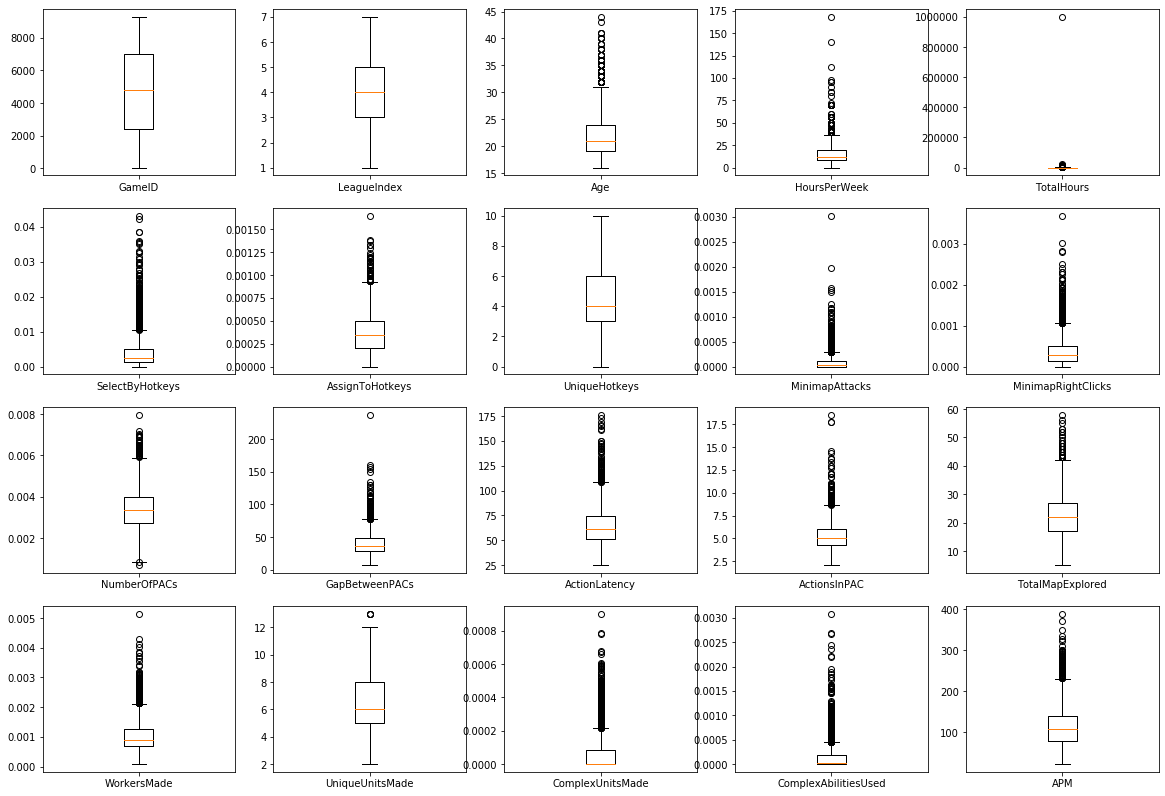

In [8]:
# box and whisker plots
seperate_boxplot(df, figsize=(20,25))
plt.show()

<p>After loading our data we decided to plot box-and-whicker plots to get a better visualization of the spread of outr data and the extent of outliers for each feature. The feature that we decided to predict was the <code>Actions Per Minute [APM]</code>; which is a measure of the actions that the player makes while playing the game. Being able to accurate predict the average APM that a player should be at could help that player to work on improving their playstyle to reduce downtime between actions.</p>
<p>Looking at the plots we see that there are a large amount of outliers for many of the features which makes sense as different players play differently, and the fact that there are different factions to play in Starcraft with different playstyles. <code>APM</code> also have a large amount of outliers which reach into the higher values which makes sense as only truelu fantastic players would play at such APM. This could later make it difficult to achieve good results as the number of outliers could prove too much for simple models to accurately predict values for APM.</p>
<p>Identifying which features to utilize for regression is also impossible to tell from these boxplots. To get a nice visualization to help with this problem we plot the pairwise join distributions:</p>

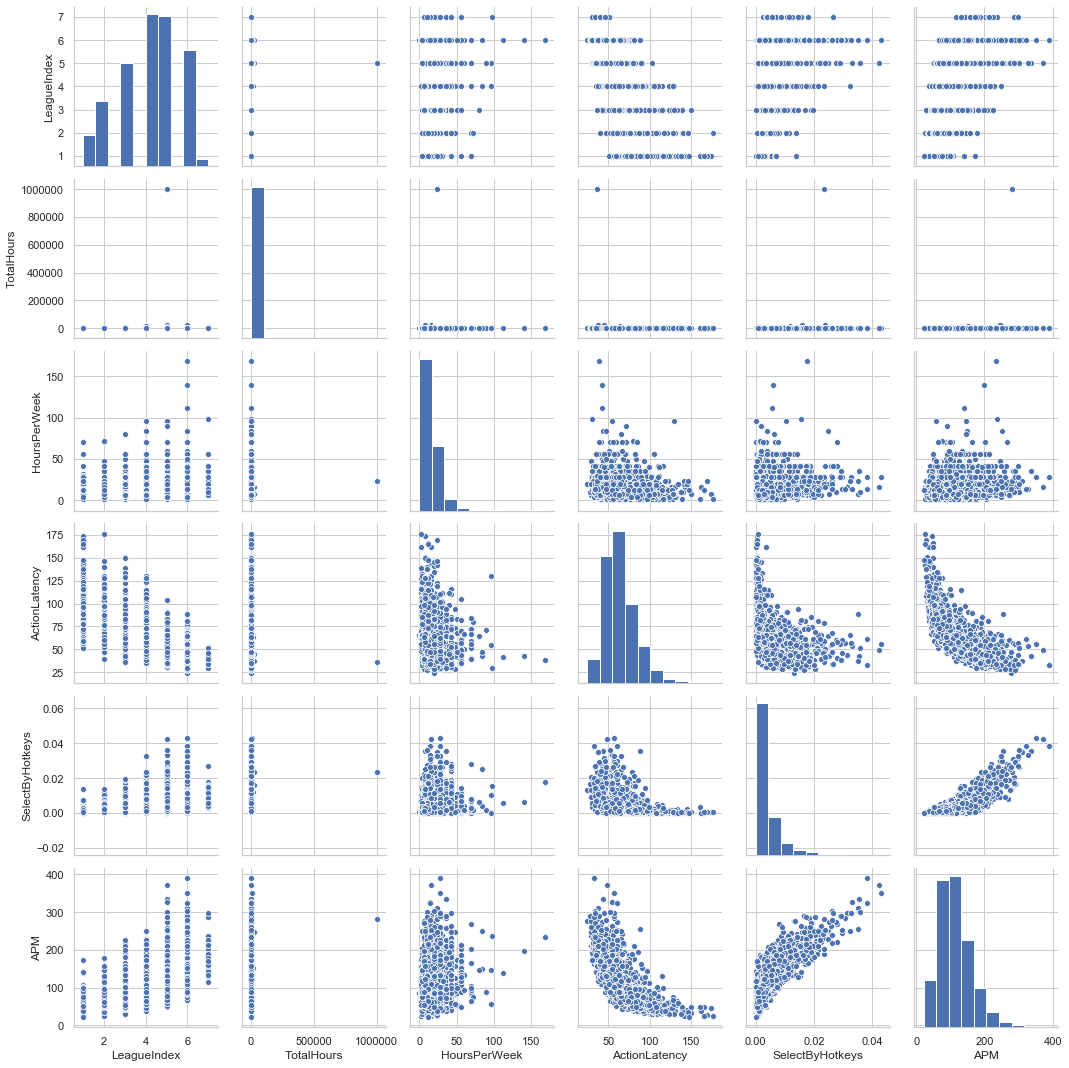

In [9]:
sns.set(style='whitegrid', context='notebook')

# create pairwise plot 
cols = ['LeagueIndex', 'TotalHours', 'HoursPerWeek', 'ActionLatency', 'SelectByHotkeys', 'APM']

sns.pairplot(df, height=2.5, vars=cols)
plt.tight_layout()

# save and display image
plt.savefig('./output/fig-housing-pairwise-dist.png', dpi=300)
plt.show()
sns.reset_orig()

<p>We chose 4 of what we though would be the most likely features to affect APM: 'LeagueIndex','HoursPerWeek', 'ActionLatency', 'SelectByHotkeys'. 
    <ul>
        <li><code>LeagueIndex</code> is a rank that the player has obtained while facing players of equal caliber, but due to it not being a continuous measure it would be difficult to use for a continuous value such as APM.</li> 
        <li><code>TotalHours</code> is the total count of the number of hours someone has played a game during its lifetime. This parameter is hard to tell if it has a linear correlation due to the large outlier so it will not be chosen.</li>
        <li><code>HourPerWeek</code> is acontinuous feature, but some players simply pick up skills faster than others and playing a large number of HoursPerWeek doesn't seem to correlate to a higher APM.</li> 
        <li><code>ActionLatency</code> is the time between actions, so it makes sense that it would affect the APM in a negatively correlated manner, however; the shape the points create is more of a polynomial or a logarithmic curve so we will save it for Polynomial Regression.</li> 
        <li>Finally <code>SelectByHotkeys</code>, surprisingly there is a positive correlation between the use of hotkeys for quick selection of units and APM; meaning players that spend less time finding their units and selecting them manually erform more APM over the cours eof the game.</li>
   </ul>
        So for the single feature linear regression problem the best candidate is the <code>SelectByHotkeys</code> feature for its positive correlation with APM. </p>

In [10]:
# create arrays to hold single feature data and APM
X = df['SelectByHotkeys'].values[:, np.newaxis]
y = df['APM'].values

# split the dataset into training, testing, and validation datasets
X_train, y_train, X_val, y_val, X_test, y_test = dataset_split(X, y)

Testing Set Shape:  (2337, 1)
Validation Set Shape:  (668, 1)
Training Set Shape:  (333, 1)


<h2>Linear Regression</h2>

<p>Regression models are utilized to predict values of target variables in a continuous scale, which makes them useful for both data analysis and prediction. They are most commonly used for:
    <ul>
        <li>Understanding relationships between variables</li>
        <li>Evaluating trends</li>
        <li>Making forecasts</li>
    </ul>
    
The idea behind Linear Regression is to find the best-fitting straight line which minimizes the sum of squared errors (SSE) for a set of data.
</p>

<h2>Fitting a Linear Regression Model via Scikit-learn</h2>

In [11]:
# create Linear Regression model
slr = LinearRegression()

# train linear regression model
slr.fit(X_train, y_train)

# predict on same data used for training (very bad)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

# display line slope and y-intercept/bias
print('Slope (w_1): %.2f' % slr.coef_[0])
print('Intercept/bias (w_0): %.2f' % slr.intercept_)

print()

print('MSE train: %.2f, test: %.2f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

print('R^2 train: %.2f, test: %.2f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

Slope (w_1): 8572.46
Intercept/bias (w_0): 79.41

MSE train: 759.36, test: 823.91
R^2 train: 0.66, test: 0.68


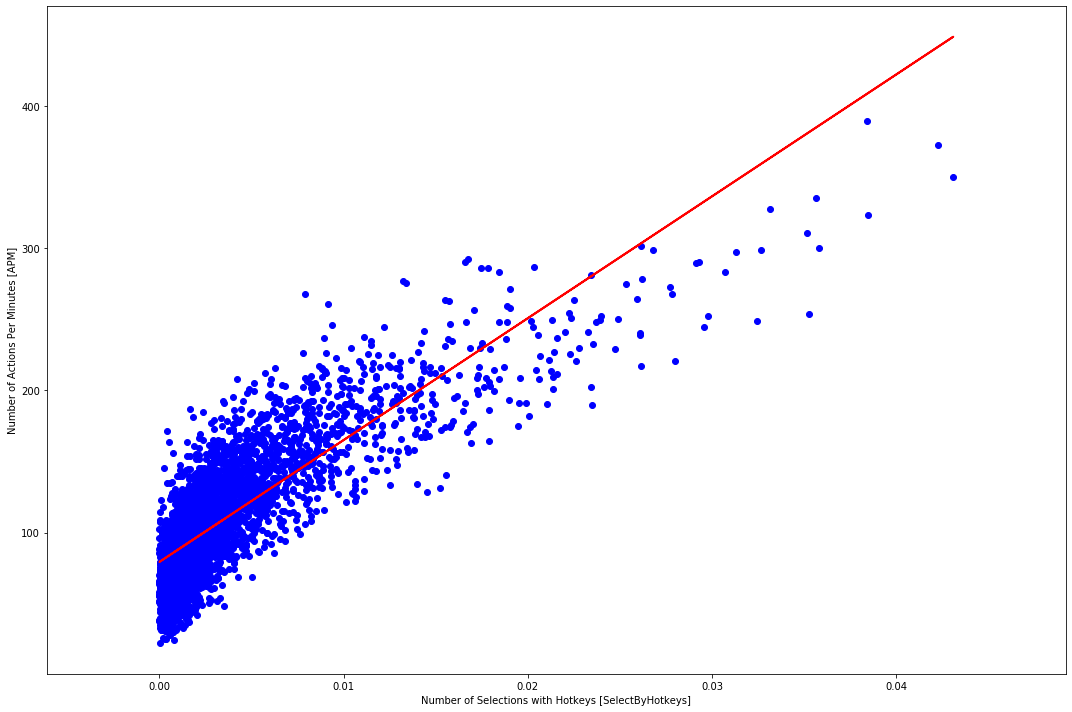

In [12]:
# To simplify our codes, predefine a function to visualize to regression line and data scatter plot.
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)
    return

plt.figure(figsize=(15,10))
lin_regplot(X, y, slr)
plt.xlabel('Number of Selections with Hotkeys [SelectByHotkeys]')
plt.ylabel('Number of Actions Per Minutes [APM]')
plt.tight_layout()
plt.savefig('./output/fig-linreg-scikit-rm.png', dpi=300)
plt.show()

<p>The regression line does quite a decent job at predicting the <code>APM</code> of the player based on their <code>SelectByHotkeys</code>. Obviously results are not perfect because on ploser examingation <code>SelectByHotkeys</code> is not perfectly linear, but it is possible to get a general idea of what <code>APM</code> a player should be playing at based on their <code>SelectByHotkeys</code>. Perhaps scaling the data could help in getting better results.</p>

In [13]:
# create list of scaling objects to test
scalers = {"StandardScaler":StandardScaler(), "MinMaxScaler":MinMaxScaler(), "RobustScaler":RobustScaler(), "Normalizer":Normalizer()}

In [14]:
for scaler in scalers:
    # Scaling
    sc = scalers[scaler]
    sc.fit(X_train)
    X_train_scaled = sc.transform(X_train)
    X_test_scaled = sc.transform(X_test)

    # Training
    slr = LinearRegression()
    slr.fit(X_train_scaled, y_train)

    # Testing
    y_train_pred = slr.predict(X_train_scaled)
    y_test_pred = slr.predict(X_test_scaled)
    
    print(scaler, 'results')
    # print results
    print('MSE train: %.2f, test: %.2f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

    print('R^2 train: %.2f, test: %.2f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))
    
    print()

StandardScaler results
MSE train: 759.36, test: 823.91
R^2 train: 0.66, test: 0.68

MinMaxScaler results
MSE train: 759.36, test: 823.91
R^2 train: 0.66, test: 0.68

RobustScaler results
MSE train: 759.36, test: 823.91
R^2 train: 0.66, test: 0.68

Normalizer results
MSE train: 2209.04, test: 2566.57
R^2 train: 0.01, test: -0.00



<p>Scaling the data did not improve performance of the model for either the training subset of the testing subset; this is most likely the slight nonlinearity of the data combined with the large number of outlier points hinders the performance too greatly. Except for Normalizer which made the model completely fail to learn most likely due to the small values in SelectedByHotkeys. The R^2 score of 0.68 shows that there is room for improvement which indicates the need for further testing with other types of architectures.</p>

<h2>Residual Plot</h2>

In [15]:
# Training
slr = LinearRegression()
slr.fit(X_train, y_train)

# Testing
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

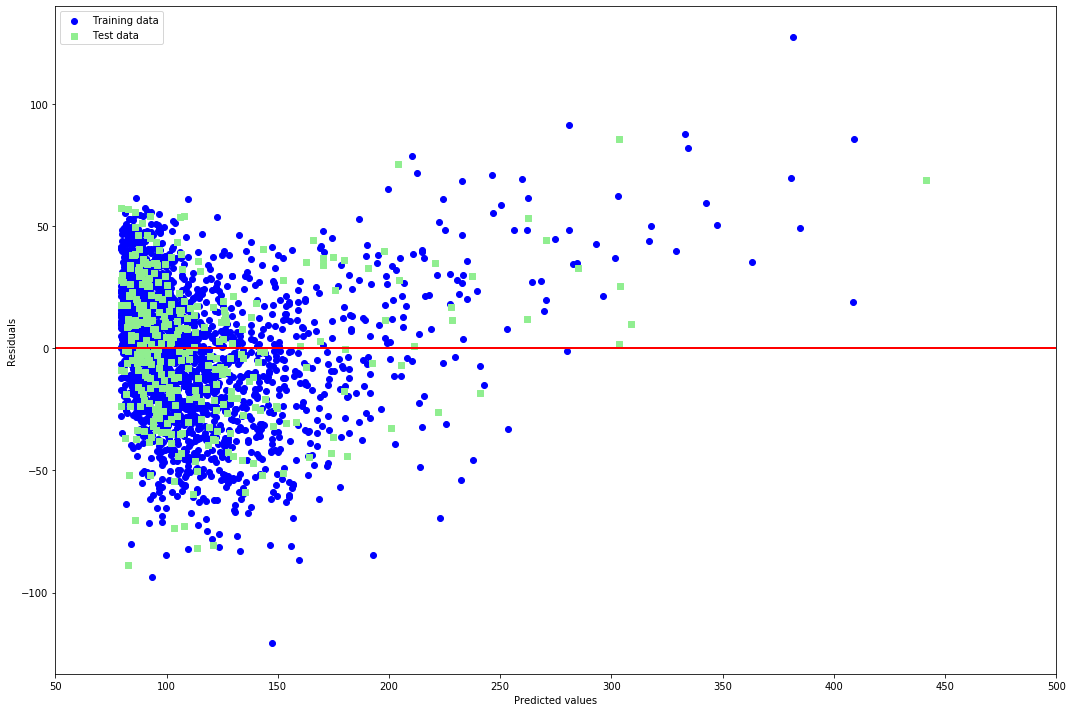

In [16]:
# plot Residual Plot and analyze
plt.figure(figsize=(15,10))
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=50, xmax=500, lw=2, color='red')
plt.xlim([50, 500])
plt.tight_layout()
plt.savefig('./output/fig-linreg-scikit-residuals.png', dpi=300)
plt.show()

<p>The residual plot is a nice visualization of the extent of outliers in the dataset. A perfect residual plot would have all points scattered closely around the line. Looking at the graph above there are a large number of outlier points, also there is a large concentration of points at the lower end of the spectrum and quite a large amount of non-centered outliers which hinder performance. The good news is that the training and testing datasets have points that are distributed similarly and thus there is no disparity between our subsets in that regard.</p>

<h2>Implementing the Linear Regression</h2>

In [17]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.0001, n_iter=20, random_state=1):
        # learning rate
        self.eta = eta
        # number of iterations
        self.n_iter = n_iter
        # random state
        self.random_state = random_state
    def fit(self, X, y):
        # generate random weights and biases
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        # list of costs
        self.cost_ = []
        
        # for each iteration calculate error between predicted and true class labels
        # then modify weights based on the errors, finally record cost
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    def net_input(self, X):
        #calculate and return output of the model
        return np.dot(X, self.w_[1:]) + self.w_[0]
    def predict(self, X):
        # return output of model
        return self.net_input(X)

MSE train: 2221.70, test: 2579.31
R^2 train: 0.00, test: -0.01

StandardScaler results
MSE train: 759.70, test: 850.87
R^2 train: 0.66, test: 0.67

MinMaxScaler results
MSE train: 1964.06, test: 2272.70
R^2 train: 0.12, test: 0.11

RobustScaler results
MSE train: 760.46, test: 841.96
R^2 train: 0.66, test: 0.67

Normalizer results
MSE train: 2209.23, test: 2568.77
R^2 train: 0.01, test: -0.01



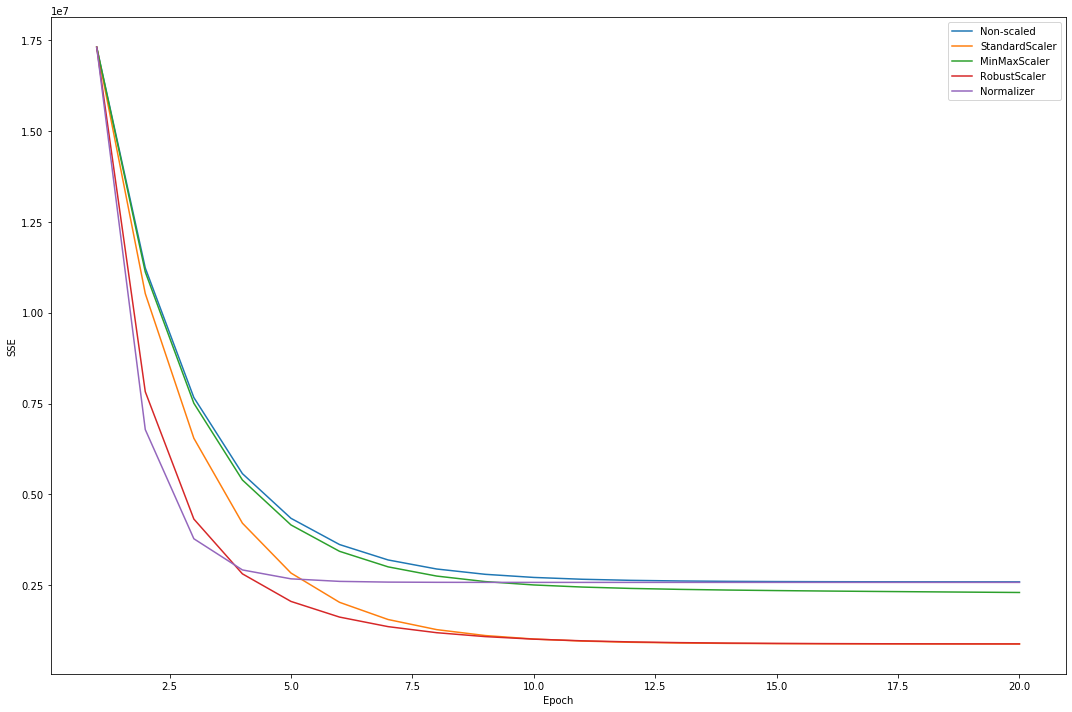

In [18]:
# create a matplotlib figure
plt.figure(figsize=(15,10))

# perform linear regression with unscaled data
lr = LinearRegressionGD()
lr.fit(X_train, y_train)

# predict on training and testing subsets
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# plot results
plt.plot(range(1, lr.n_iter+1), lr.cost_, label="Non-scaled")

# print results
print('MSE train: %.2f, test: %.2f' % (
mean_squared_error(y_train, y_train_pred),
mean_squared_error(y_test, y_test_pred)))

print('R^2 train: %.2f, test: %.2f' % (
r2_score(y_train, y_train_pred),
r2_score(y_test, y_test_pred)))
print()

# for each scaler object perform training and compare results to one another
for scaler in scalers:
    # scale the data
    sc_x = scalers[scaler]
    X_std = sc_x.fit_transform(X_train)
    X_std_test = sc_x.fit_transform(X_test)

    # perform linear regression
    lr = LinearRegressionGD()
    lr.fit(X_std, y_train)
    
    # predict on training and testing subsets
    y_train_pred = lr.predict(X_std)
    y_test_pred = lr.predict(X_std_test)
    
    print(scaler, 'results')
    # print results
    print('MSE train: %.2f, test: %.2f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

    print('R^2 train: %.2f, test: %.2f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))
    print()

    # plot results
    plt.plot(range(1, lr.n_iter+1), lr.cost_, label=scaler)
    plt.ylabel('SSE')
    plt.xlabel('Epoch')
    plt.tight_layout()
plt.legend()
plt.savefig('./output/fig-linreg-gd-cost.png', dpi=300)
plt.show()

In [19]:
# same as before RobustScaler performed best so retrain the model and plot results
# scale the data
sc_x = RobustScaler()
X_std = sc_x.fit_transform(X_train)

# perform linear regression
lr = LinearRegressionGD()
lr.fit(X_std, y_train)

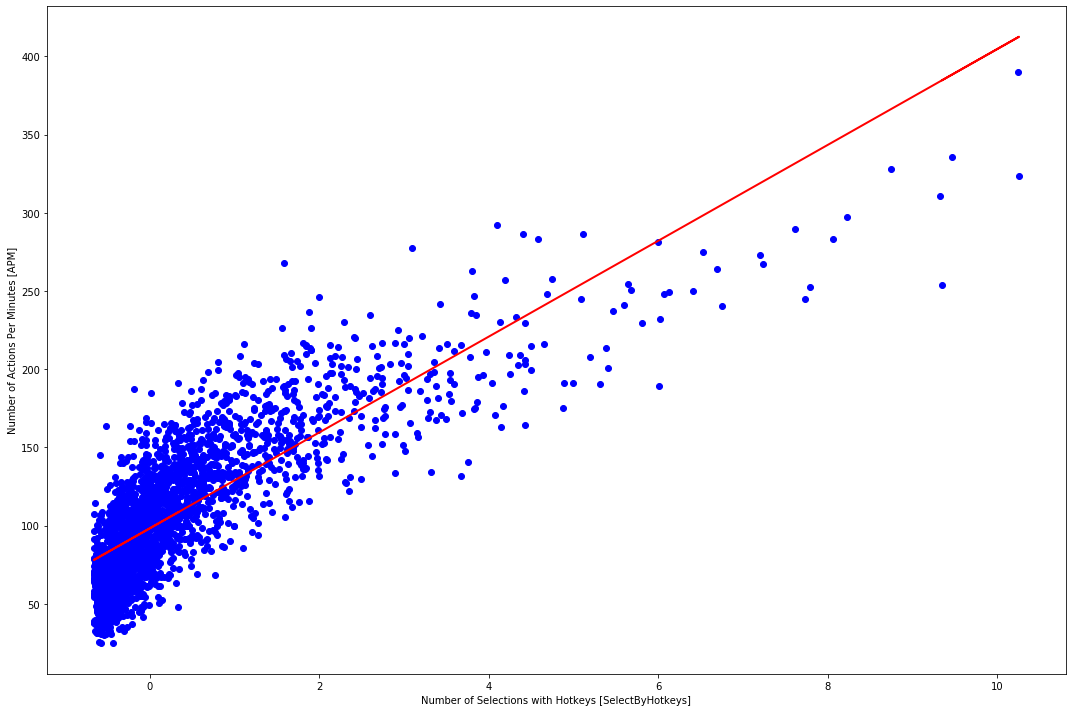

In [20]:
# plot regression line and scatter matrix of lines
plt.figure(figsize=(15,10))
lin_regplot(X_std, y_train, lr)
plt.xlabel('Number of Selections with Hotkeys [SelectByHotkeys]')
plt.ylabel('Number of Actions Per Minutes [APM]')
plt.tight_layout()
plt.savefig('./output/fig-linreg-gd-rm.png', dpi=300)
plt.show()

<p>Like with the Scikit-Learn LinearRegressor, performing Linear Regression with Gradient Descent model requires training the model on our dataset. The difference is that with Gradient Descent weights are modified in the opposite direction of the gradient to lower the overall loss of the network rather than based on the error. One change we had to make to the provided model is lowering the learning rate from 0.001 to 0.0001; without this change the SSE increased in the final epoch and the model failed to predict correctly..</p>
<p>Looking at the curve for loss over time, <code>RobustScaling</code> and <code>StandardScaler</code> helped the model perform better and converge quicker. Not only that, but the model trained on the non-scaled data failed to learn the problem.</p>
<p>Now that we have done LinearRegression it is time to move onto utilizing polynomial features and lines to better fit data that is more polynomial in correlation. </p>

<h2>Polynomial Regression</h2>
<p>Linear Regression has the downfall that it assumes the relationship between the explanatory andresponse varaibles are linear in nature; this assumption does not hold true in the real world, and this is seen in the relationship between <code>ActionLatency</code>, and <code>APM</code>. Thus let's see how polynomial features will affect the accuracy of linear regression.</p>

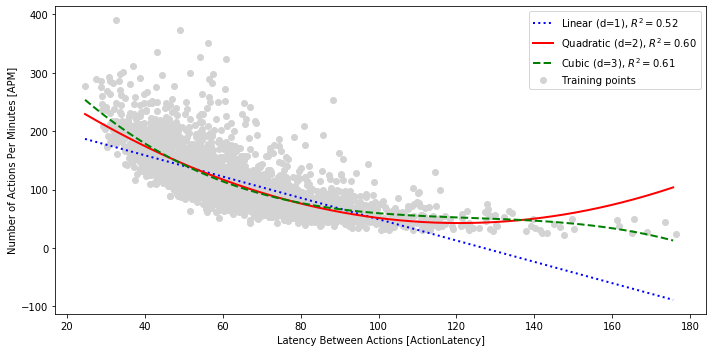

In [21]:
from sklearn.preprocessing import PolynomialFeatures
X_lin = df['ActionLatency'].values[:, np.newaxis]
regr = LinearRegression()

# Create quadratic features for Polynomial Regression
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X_lin)
X_cubic = cubic.fit_transform(X_lin)

# fit features
X_fit = np.arange(X_lin.min(), X_lin.max(), 1)[:, np.newaxis]
regr = regr.fit(X_lin, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X_lin))
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# plot results
plt.figure(figsize=(10,5))
plt.scatter(X_lin, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit,
label='Linear (d=1), $R^2=%.2f$' % linear_r2,
color='blue',
lw=2,
linestyle=':')

plt.plot(X_fit, y_quad_fit,
label='Quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
color='red',
lw=2,
linestyle='-')

plt.plot(X_fit, y_cubic_fit,
label='Cubic (d=3), $R^2=%.2f$' % cubic_r2,
color='green',
lw=2,
linestyle='--')

plt.xlabel('Latency Between Actions [ActionLatency]')
plt.ylabel('Number of Actions Per Minutes [APM]')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/fig-polyreg-degree.png', dpi=300)
plt.show()

<p>Different degrees of lines have the possibility to fit to the data more effectively than the simple single degree line. Line such as Quadratic degree = 2 and Cubic degree = 3 lines are lines which have a curve to them, and looking at the R^2 score we can see that perhaps the quadratic and cubic lines fit the data better than the linear line. Linear performed worse than with SelectedByHotkeys due to the more curved nature of the correlation. Quadratic features and Cubic features fit the curve much better than linear features, outliers are still a problem and lower the overall score of the model.</p>

<h2>Multivariate Cases</h2>
<p>Since its unrealistic to only use a single data feature to predict a value, its time to perform regression utilizing all of the data in our dataset, and see if performance improves.</p>

In [22]:
############## perform regression on cubic features ##############
regr = LinearRegression()
print('[Linear]')
print('#Features: %d' % X_train.shape[1])

# train model, and perform predictions
regr = regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

# output results
print('MSE train: %.2f, test: %.2f' % (
mean_squared_error(y_train, y_train_pred),
mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (
r2_score(y_train, y_train_pred),
r2_score(y_test, y_test_pred)))


############## perform regression on quadratic features ##############
print('\n[Quadratic]')
# create quadratic features
X_quad_train = quadratic.fit_transform(X_train)
X_quad_test = quadratic.fit_transform(X_test)
print('#Features: %d' % X_quad_train.shape[1])

# train model, and perform predictions
regr = regr.fit(X_quad_train, y_train)
y_train_pred = regr.predict(X_quad_train)
y_test_pred = regr.predict(X_quad_test)

# output results
print('MSE train: %.2f, test: %.2f' % (
mean_squared_error(y_train, y_train_pred),
mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (
r2_score(y_train, y_train_pred),
r2_score(y_test, y_test_pred)))


############## perform regression on cubic features ##############
print('\n[Cubic]')
# create cubix features
X_cubic_train = cubic.fit_transform(X_train)
X_cubic_test = cubic.fit_transform(X_test)
print('#Features: %d' % X_cubic_train.shape[1])

# train model, and perform predictions
regr = regr.fit(X_cubic_train, y_train)
y_train_pred = regr.predict(X_cubic_train)
y_test_pred = regr.predict(X_cubic_test)

# output results
print('MSE train: %.2f, test: %.2f' % (
mean_squared_error(y_train, y_train_pred),
mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (
r2_score(y_train, y_train_pred),
r2_score(y_test, y_test_pred)))

[Linear]
#Features: 1
MSE train: 759.36, test: 823.91
R^2 train: 0.66, test: 0.68

[Quadratic]
#Features: 3
MSE train: 657.88, test: 810.42
R^2 train: 0.70, test: 0.68

[Cubic]
#Features: 4
MSE train: 604.62, test: 777.00
R^2 train: 0.73, test: 0.70


<p>After training the models we see that the Linear model performs the same as before same underfitting and all. The Quadratic model doesn't perform much better and instead has slight overfitting. The Cubic model had better performance than the Linear and Quadratic models, but still seems to overfit slightly which is to be expected.</p>

<h2>Decision Tree Regression</h2>

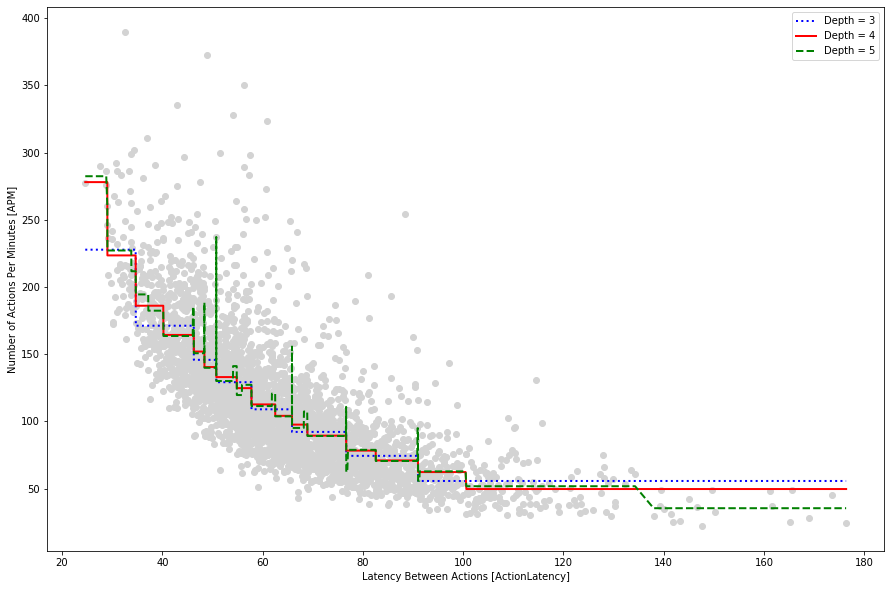

In [23]:
# craete a tree of depth=3 and train model on data
tree_3 = DecisionTreeRegressor(max_depth=3)
tree_3.fit(X_lin, y)
tree_4 = DecisionTreeRegressor(max_depth=4)
tree_4.fit(X_lin, y)
tree_5 = DecisionTreeRegressor(max_depth=5)
tree_5.fit(X_lin, y)
sort_idx = X_lin.flatten().argsort()

plt.figure(figsize=(15,10))
plt.scatter(X_lin, y, color='lightgray')

plt.plot(X_lin[sort_idx], tree_3.predict(X_lin)[sort_idx],
color='blue',
lw=2,
linestyle=':', label='Depth = 3')

plt.plot(X_lin[sort_idx], tree_4.predict(X_lin)[sort_idx],
color='red',
lw=2,
linestyle='-', label='Depth = 4')

plt.plot(X_lin[sort_idx], tree_5.predict(X_lin)[sort_idx],
color='green',
lw=2,
linestyle='--', label='Depth = 5')

plt.legend()
plt.xlabel('Latency Between Actions [ActionLatency]')
plt.ylabel('Number of Actions Per Minutes [APM]')
plt.savefig('./output/fig-treereg-depth.png', dpi=300)
plt.show()

<p>Decision Trees create different criteria for choosing paths in the tree to finally get to a decision. Decision trees can be created with different depths with the idea that more criteria to work with will result in bestter predicitions. With our dataset increading the max depth creates larger fluctuations, but also seems to help the tree account for outliers more effectively.</p>

<h2>Random Forest Regression</h2>

MSE train: 131.22, test: 936.02
R^2 train: 0.94, test: 0.63


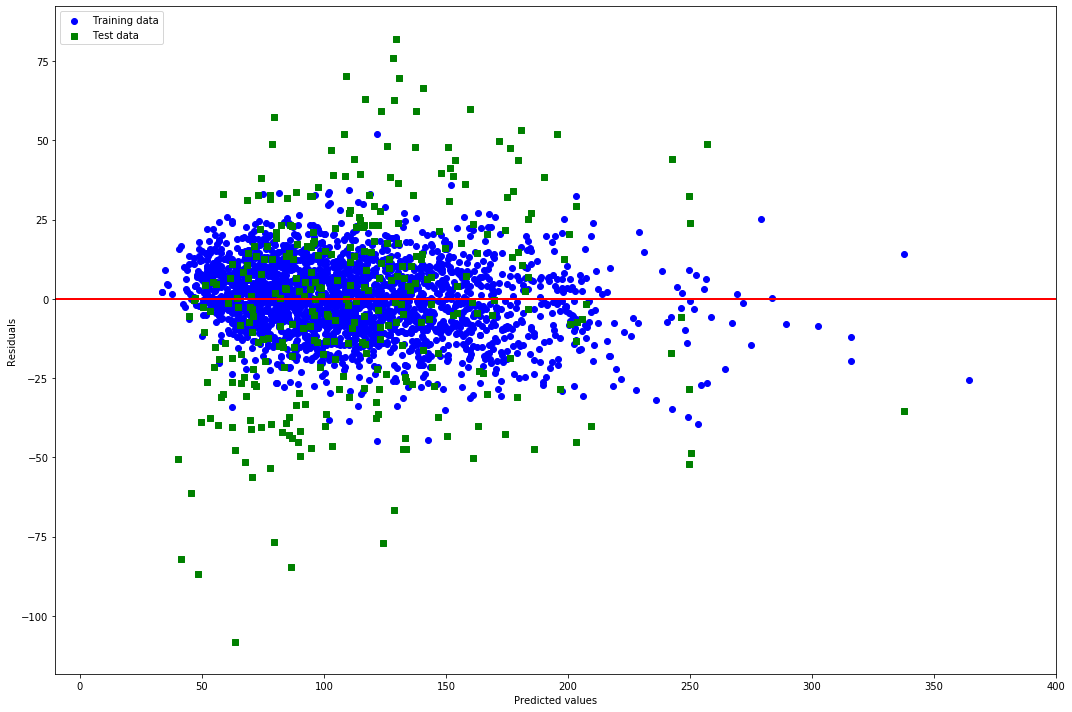

In [24]:
from sklearn.inspection import permutation_importance
forest = RandomForestRegressor(n_estimators=1000,
criterion='mse',
random_state=1,
n_jobs=-1)
forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.2f, test: %.2f' % (
mean_squared_error(y_train, y_train_pred),
mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (
r2_score(y_train, y_train_pred),
r2_score(y_test, y_test_pred)))

# Residual plot
plt.figure(figsize=(15,10))
plt.scatter(y_train_pred,
y_train_pred - y_train,
c='blue',
marker='o',
label='Training data')

plt.scatter(y_test_pred,
y_test_pred - y_test,
c='green',
marker='s',
label='Test data')

plt.legend()
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=400, lw=2, color='red')
plt.xlim([-10, 400])
plt.tight_layout()
plt.savefig('./output/fig-forestgre-residuals.png', dpi=300)
plt.show()

<p>The results of using Random Forest Rregression shows that there is a small amount of overfitting, which can be seen in the R^2 and MSE scores achieved. We limited the max depth to 8 to prevent the model from forming too deep of a model that could extrememly overfit the training data.<br>Since before we looked at the effect of depth on fitting the curve to the data, we try to see the correlation between depth and overfitting and performance.</p>

In [25]:
mse_scores_training = []
mse_scores_testing = []

r_2_scores_training = []
r_2_scores_testing = []

max_depth = 20

for i in range(1,max_depth):    
    forest = RandomForestRegressor(n_estimators=1000,
    criterion='mse',
    random_state=1,
    n_jobs=-1, max_depth=i)
    forest.fit(X_train, y_train)
    y_train_pred = forest.predict(X_train)
    y_test_pred = forest.predict(X_test)
    
    mse_training = mean_squared_error(y_train, y_train_pred)
    mse_testing = mean_squared_error(y_test, y_test_pred)
    
    r_2_training = r2_score(y_train, y_train_pred)
    r_2_testing = r2_score(y_test, y_test_pred)
    
    # append results to lists for later comparison and graphing
    mse_scores_training.append(mse_training)
    mse_scores_testing.append(mse_testing)
    r_2_scores_training.append(r_2_training)
    r_2_scores_testing.append(r_2_testing)

    MSE Training  MSE Testing  R2 Training  R2 Testing
1    1031.202504  1302.229030     0.535875    0.490381
2     669.802123   874.478975     0.698534    0.657778
3     590.947953   761.879963     0.734025    0.701843
4     576.470760   743.598680     0.740541    0.708997
5     551.002734   738.752499     0.752004    0.710894
6     518.994278   741.194426     0.766410    0.709938
7     479.775530   746.519024     0.784062    0.707855
8     436.388861   753.898789     0.803589    0.704966
9     390.385134   764.033560     0.824295    0.701000
10    345.430183   777.933217     0.844528    0.695561
11    302.843029   795.372780     0.863696    0.688736
12    265.404109   813.481726     0.880546    0.681649
13    233.195258   833.647500     0.895043    0.673757
14    207.332127   852.314524     0.906684    0.666452
15    186.902813   869.773805     0.915878    0.659620
16    171.202374   884.671959     0.922945    0.653789
17    159.475208   897.687628     0.928223    0.648696
18    151.

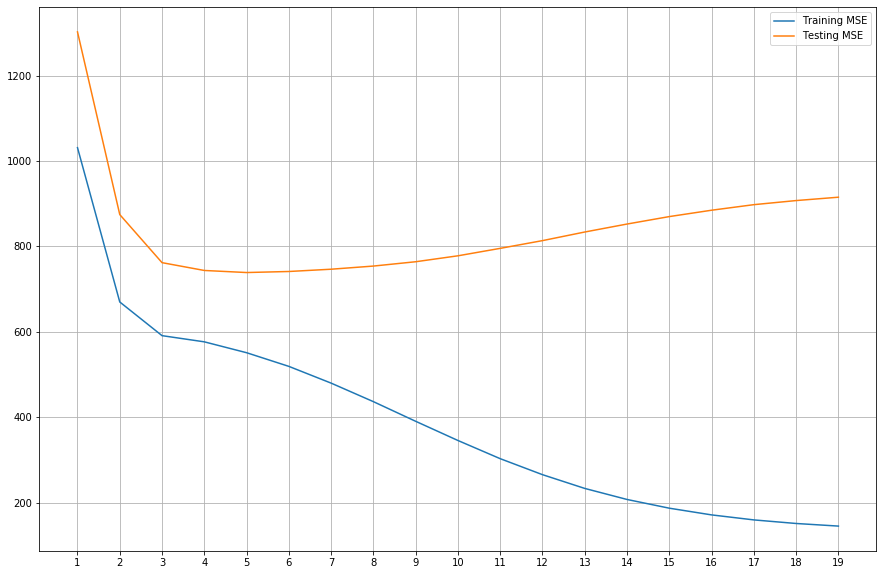

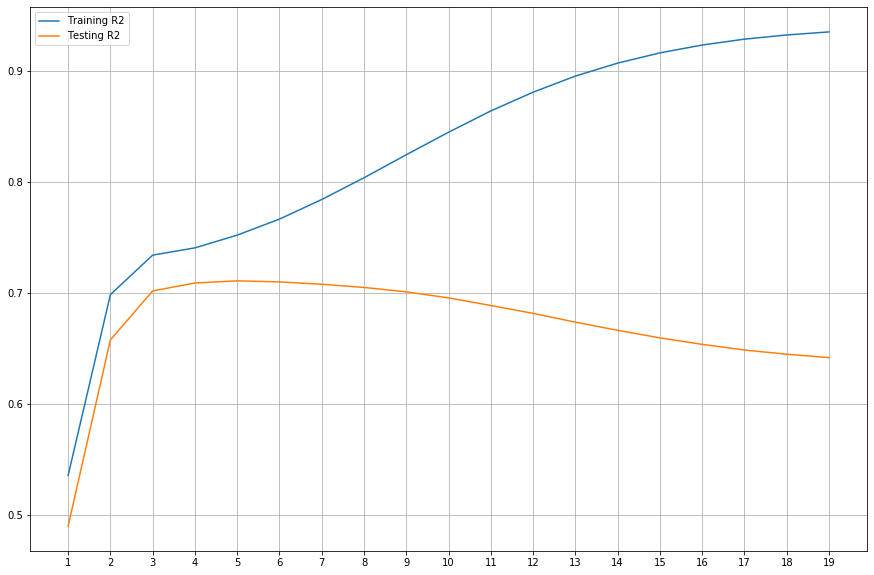

In [26]:
# show comparison of MSE and R^2 between models of different max depth
print(pd.DataFrame({"MSE Training":mse_scores_training, "MSE Testing":mse_scores_testing, 
              "R2 Training":r_2_scores_training, "R2 Testing":r_2_scores_testing}, index=range(1,max_depth)))

# plot graphs of MSE and R^2 between models of different max depth to show overfitting
plt.figure(figsize=(15,10))
plt.plot(range(1,max_depth), mse_scores_training, label="Training MSE")
plt.plot(range(1,max_depth), mse_scores_testing, label="Testing MSE")
plt.xticks(range(1,max_depth))
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15,10))
plt.plot(range(1,max_depth), r_2_scores_training, label="Training R2")
plt.plot(range(1,max_depth), r_2_scores_testing, label="Testing R2")
plt.xticks(range(1,max_depth))
plt.legend()
plt.grid()
plt.show()

<p>Comparing performance of trees of different depths we see that there is a point at Depth = 4 where depth begins causing a rapid increase in the overfitting of the model. The problem is that the model doesn't gauge performance based on error of a validation set, but rather on the performance of the training set. The depth of the tree cannot be allowed to increase infinitely or it will cause overfitting, but also will increase the computational cost to perform a prediction with the model. For our dataset a tree with max depth of 4 gives the best performance; though it barely performed better than linear regression utilizing Cubic features.</p>

<h2>Visualizing Feature Importance Using Random Tree Classifier</h2>

In [27]:
# need to get all features so we split our data again
# create arrays to hold single feature data and APM
cols = df.columns[1:-1]
X = df[cols].values
y = df.values[:,-1]

# split the dataset into training, testing, and validation datasets
X_train, y_train, X_val, y_val, X_test, y_test = dataset_split(X, y)

Testing Set Shape:  (2337, 18)
Validation Set Shape:  (668, 18)
Training Set Shape:  (333, 18)


MSE train: 9.58, test: 80.67
R^2 train: 1.00, test: 0.97

 1) SelectByHotkeys                0.642386
 2) ActionLatency                  0.220683
 3) ActionsInPAC                   0.081752
 4) NumberOfPACs                   0.026928
 5) GapBetweenPACs                 0.006903
 6) WorkersMade                    0.004159
 7) MinimapRightClicks             0.002898
 8) AssignToHotkeys                0.002128
 9) MinimapAttacks                 0.001876
10) TotalHours                     0.001624
11) Age                            0.001607
12) TotalMapExplored               0.001484
13) HoursPerWeek                   0.001292
14) UniqueHotkeys                  0.001098
15) ComplexAbilitiesUsed           0.000985
16) UniqueUnitsMade                0.000911
17) LeagueIndex                    0.000707
18) ComplexUnitsMade               0.000578


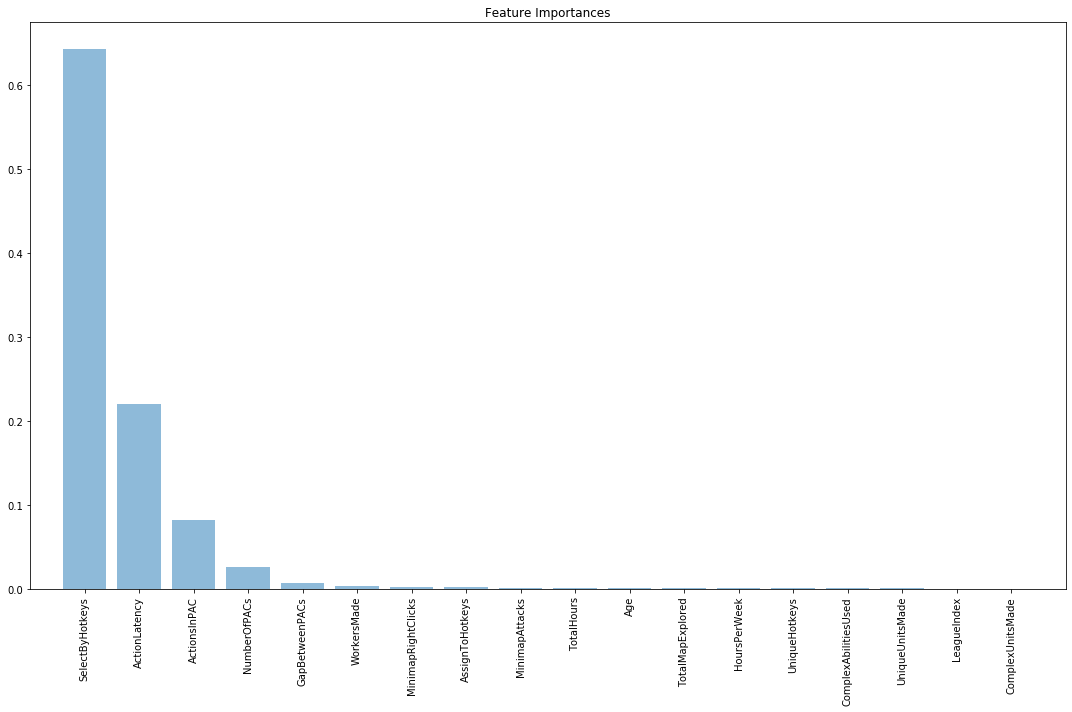

In [28]:
# create a new Tree and train on all features
forest = RandomForestRegressor(n_estimators=1000,
criterion='mse',
random_state=1,
n_jobs=-1)

# train model on subset
forest.fit(X_train, y_train)

# predict on data
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)


# calculate and output metrics
mse_training = mean_squared_error(y_train, y_train_pred)
mse_testing = mean_squared_error(y_test, y_test_pred)
    
r_2_training = r2_score(y_train, y_train_pred)
r_2_testing = r2_score(y_test, y_test_pred)

print('MSE train: %.2f, test: %.2f' % (mse_training, mse_testing))    
print('R^2 train: %.2f, test: %.2f' % (r_2_training, r_2_testing))
print()


# get importance of all features and display their importance in a final decision
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
    cols[indices[f]],
    importances[indices[f]]))
plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
importances[indices],
align='center',
alpha=0.5)
plt.xticks(range(X_train.shape[1]),
cols[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.savefig('./output/fig-forest-feature-importances.png', dpi=300)
plt.show()

<p>Looking at the bar graph we see clearly that <code>SelectByHotkeys, ActionLatency, and ActionsInPAC</code> are the most important features that the RandomTreeClassifier utilizes for predictions. Which speaks well for our choice of parameters for Simple Linear and Multivariate Regression before. This is because the correlation of these features is more linear than compared to something like LeagueIndex which isn't continous. It can be noted that performance increased greatly with a 0.95 R^2 score for the testing set which is a huge increase of best R^2 score for RandomForestClassifier with a single feature of 0.71. Though not strictly necessary for this model finding the importance of features is an excellent way to reduce redundant features in an attempt to simplify the model and improve performance.</p>

<h2>Manual Feature Selection Based on Training</h2>

In [29]:
# change data to most relevant features
# create arrays to hold single feature data and APM
cols = ["SelectByHotkeys", "ActionLatency", "ActionsInPAC"]
X = df[cols].values
y = df.values[:,-1]

# split the dataset into training, testing, and validation datasets
X_train, y_train, X_val, y_val, X_test, y_test = dataset_split(X, y)

Testing Set Shape:  (2337, 3)
Validation Set Shape:  (668, 3)
Training Set Shape:  (333, 3)


In [30]:
# create a new Tree and train on all features
forest = RandomForestRegressor(n_estimators=1000,
criterion='mse',
random_state=1,
n_jobs=-1)

# train model on subset
forest.fit(X_train, y_train)

# predict on data
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)


# calculate and output metrics
mse_training = mean_squared_error(y_train, y_train_pred)
mse_testing = mean_squared_error(y_test, y_test_pred)
    
r_2_training = r2_score(y_train, y_train_pred)
r_2_testing = r2_score(y_test, y_test_pred)

print('MSE train: %.2f, test: %.2f' % (mse_training, mse_testing))    
print('R^2 train: %.2f, test: %.2f' % (r_2_training, r_2_testing))
print()

MSE train: 15.29, test: 116.85
R^2 train: 0.99, test: 0.95



<p>Since the number of redundant features was high when training utilizing all the features when we take on the top 3 features we can achieve a similar performance as with all the features of the dataset. This in turn with the fewer features reduces the complexity of the tree and allows for faster predicitions. Performing feature selection in this was is just one method of features selection; other methods such as Principal Component Analysis(PCA) utilize the Singular value decomposition(SVD) which is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.</p>

<h2>Feature Selection Using PCA</h2>
<p>PCA is a unsupervised
dimension reduction technique since it does not require the class labels; while the latter is a supervised dimension reduction technique as the labels are used for computing the information gain for each node split. However, PCA is a feature extraction technique since data is not simply selected the input data is centered but not scaled for each feature before applying the SVD.</p>

In [31]:
from sklearn.decomposition import PCA, TruncatedSVD, FactorAnalysis
from sklearn.feature_selection import SelectPercentile, SelectKBest
# split features from class label
cols = df.columns[1:-1]
X = df[cols].values
y = df.values[:,-1]

# we leave the default parameters that scikit-learn provides to remove any chance of irregular parameters that we could choose
pca = PCA(n_components = 11, svd_solver='full')
X = pca.fit_transform(X)
# split the dataset into training, testing, and validation datasets
X_train, y_train, X_val, y_val, X_test, y_test = dataset_split(X, y)

Testing Set Shape:  (2337, 11)
Validation Set Shape:  (668, 11)
Training Set Shape:  (333, 11)


In [32]:
# create a new Tree and train on all features
forest = RandomForestRegressor(n_estimators=1000,
criterion='mse',
random_state=1,
n_jobs=-1)

# train model on subset
forest.fit(X_train, y_train)

# predict on data
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)


# calculate and output metrics
mse_training = mean_squared_error(y_train, y_train_pred)
mse_testing = mean_squared_error(y_test, y_test_pred)
    
r_2_training = r2_score(y_train, y_train_pred)
r_2_testing = r2_score(y_test, y_test_pred)

print('MSE train: %.2f, test: %.2f' % (mse_training, mse_testing))    
print('R^2 train: %.2f, test: %.2f' % (r_2_training, r_2_testing))

MSE train: 27.45, test: 203.14
R^2 train: 0.99, test: 0.92


<p>Scikit-Learn's implementation of PCA runs in a way where is is better suited to datasets where there are more features than data, because of this we tested and chose an optimal number of features = 11. Performance is similar to when selecting the features using the RandomForestClassifier feature importances; however, the number of compoenents was significantly more due to the centering.</p>

<h2>Final Remarks</h2>
<ul>
    <li>Regression models are an excellent source of information and can provide information about the importance of data features and the class label, and are useful for estimating the value of the class label based on the data features.</li>
    <li>Outliers are a huge problem when it comes to regression due to the affect they have on the regression line.</li>
</ul>